# Density-based Anomaly Detection

In [ ]:
* 밀도기반 이상치 탐지란, 
- 주어진 데이터를 바탕으로 각 객체들이 생성될 확률을 추정하여
- 새로운 데이터가 생성될 확률이 낮을 경우 이상치로 판단함.

* 아래의 4가지 밀도기반 이상치 탐지기법들을 소개함
1. Single Gassusian -> parametric기법
2. Gaussian Mixture -> parametric기법
3. Parzen Window Density Estimation -> non-parametric기법
4. Local Outlier Factor(LoF) -> non-parametric기법

## Gaussian

In [ ]:
* 모든 데이터가 '하나'의 가우시안(정규)분포로부터 생성됨을 가정함.
* 학습은 정상데이터들의 가우시안분포의 평균(mu)과 공분산(var)행렬을 추정하며 이루어짐
* 테스트는 새로운 데이터가 생성확률이 낮으면 이상치, 높으면 정상으로 구분함

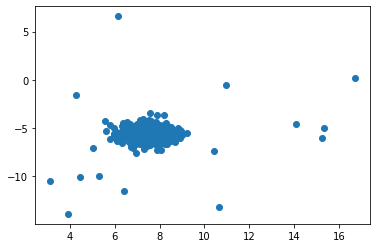

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=500, centers=1, cluster_std=0.60, random_state=5)
X_append, y_true_append = make_blobs(n_samples=20,centers=1, cluster_std=5,random_state=5)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] 
plt.scatter(X[:,0],X[:,1],marker="o")

In [47]:
X

array([[ 6.95639799, -5.53308968],
       [ 6.71474654, -5.01864886],
       [ 7.60029949, -5.36237345],
       ...,
       [16.70130116,  0.19681847],
       [ 6.15418548,  6.59371936],
       [15.22230759, -5.99451461]])

In [48]:
def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    # comput std of X
    sigma = np.std(X,axis=0)
    print(mu, var, sigma)
    return mu,var, sigma
mu, var, sigma = estimateGaussian(X)

[ 7.47238448 -5.56412287] [1.01680768 1.22046707] [1.00836882 1.10474752]


In [49]:
def multivariateGaussian(X, mu, sigma):
    k = len(mu)
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)

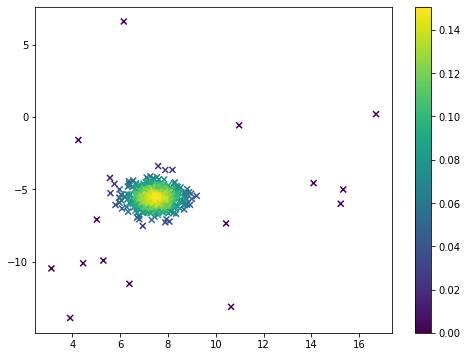

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

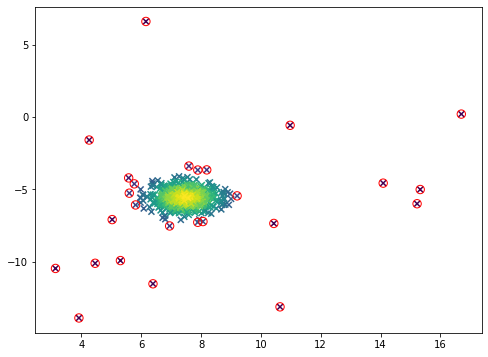

In [55]:
epsilon = 0.04 # threshold
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

## Mixture of Gaussian

In [ ]:
* 여러가지의 가우시안(정규)분포로부터 데이터가 생성됬음을 가정함
* Expectation-Maximization(EM)알고리즘을 통해, 각 가우시안분포의 중심점(조건확률)이 끝날때까지 반복함

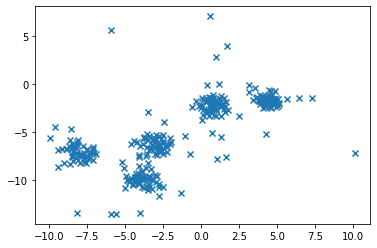

In [41]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5, cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5, cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)
plt.scatter(X_train[:,0],X_train[:,1],marker="x");

[-1.83507767 -5.34263936] [18.71750414 12.12645659] [4.32637309 3.48230622]


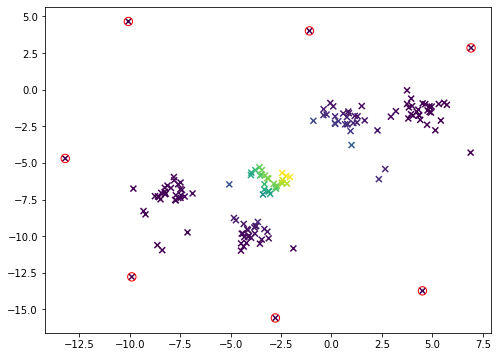

In [70]:
epsilon_MG = 0.000003
mu, var, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p< epsilon_MG)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)

In [72]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5, covariance_type = 'full', random_state=0)
gm.fit(X_train)

GaussianMixture(n_components=5, random_state=0)

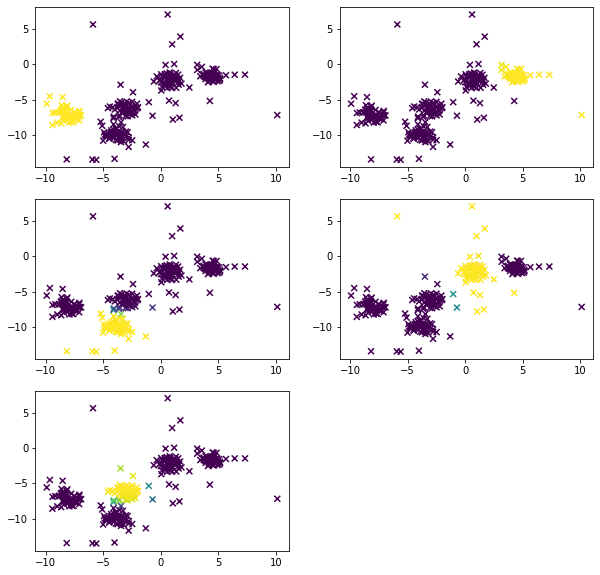

In [73]:
# 아래 predict_proba()를 통해 5개의 클러스터 중 어느 군집에 속하는지 확률값을 찾음
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

## Parzen Window Density Estimation

In [ ]:
* 위 가우시안기법들은 데이터가 특정분포를 따른다고 가정하지만, 
* 파젠 윈도우 기법에선 데이터가 특정분포를 따른다고 가정하지 않음 ==> non-parametric기법
* 확률밀도를 추정할 때, 데이터의 수는 고정되어 있으므로 적절한 V(부피)를 찾는 문제로 귀결되지만,
* 파젠 윈도우 기법에선 V(부피)를 고정하고, "k(V안에 포함되는 데이터 수)"를 찾음 ==> 커널 밀도 추정

C:\Users\ppuya\anaconda3\envs\jff\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


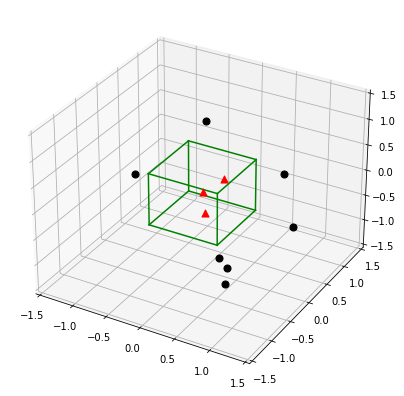

In [75]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.set_aspect("auto")

# Plot Points

# samples within the cube
X_inside = np.array([[0,0,0],[0.2,0.2,0.2],[0.1, -0.1, -0.3]])

X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                  [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                  [0.7,-0.6,-0.8]])

for row in X_inside:
    ax.scatter(row[0], row[1], row[2], color="r", s=50, marker='^')

for row in X_outside:
    ax.scatter(row[0], row[1], row[2], color="k", s=50)

# Plot Cube
h = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(h,h,h))), 2):
    if np.sum(np.abs(s-e)) == h[1]-h[0]:
        ax.plot3D(*zip(s,e), color="g")

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()

In [81]:
# window function

def window_function(x_vec, unit_len=1):
#     """
#     Implementation of the window function. Returns 1 if 3x1-sample vector
#     lies within a origin-centered hypercube, 0 otherwise.

#     """
    for row in x_vec:
        if np.abs(row) > (unit_len/2):
            return 0
    return 1

In [114]:
X_all = np.vstack((X_inside,X_outside))
assert(X_all.shape == (10,3))

k_n = 0
for row in X_all:
    k_n += window_function(row.reshape(3,1))

print('하이퍼큐브 내 속하는 데이터의 수(=k):', k_n)
print('하이퍼큐브 내 속하지 않는 데이터의 수:', len(X_all) - k_n)

하이퍼큐브 내 속하는 데이터의 수(=k): 3
하이퍼큐브 내 속하지 않는 데이터의 수: 7


In [115]:
# 파젠 윈도우의 확률밀도값을 나타냄!!

def parzen_window_est(x_samples, h=1, center=[0,0,0]):
#     '''
#     Implementation of the Parzen-window estimation for hypercubes.

#     Keyword arguments:
#         x_samples: A 'n x d'-dimensional numpy array, where each sample
#             is stored in a separate row.
#         h: The length of the hypercube.
#         center: The coordinate center of the hypercube

#     Returns the probability density for observing k samples inside the hypercube.

#     '''
    dimensions = x_samples.shape[1]

    assert (len(center) == dimensions)#'Number of center coordinates have to match sample dimensions'
    k = 0
    for x in x_samples:
        is_inside = 1
        for axis,center_point in zip(x, center):
            if np.abs(axis-center_point) > (h/2):
                is_inside = 0
        k += is_inside
    return (k / len(x_samples)) / (h**dimensions)

print('p(x) =', parzen_window_est(X_all, h=1))

p(x) = 0.3


#### example(h: hypercube의 각면의 길이)

In [97]:
# Generate 10,000 random 2D-patterns
mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)

print(x_2Dgauss.shape)

(10000, 2)


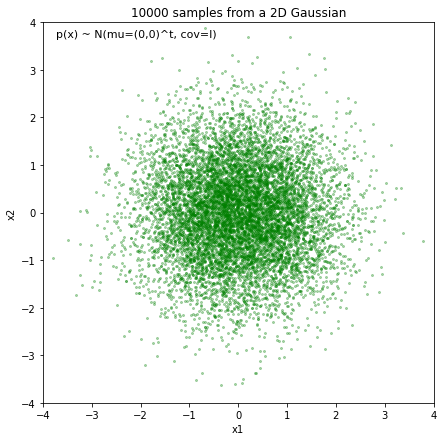

In [117]:
#from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x_2Dgauss[:,0], x_2Dgauss[:,1],
        marker='o', color='green', s=4, alpha=0.3)
plt.title('10000 samples from a 2D Gaussian')
plt.ylabel('x2')
plt.xlabel('x1')
ftext = 'p(x) ~ N(mu=(0,0)^t, cov=I)'
plt.figtext(.15,.85, ftext, fontsize=11, ha='left')
plt.ylim([-4,4])
plt.xlim([-4,4])

plt.show()

In [120]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [121]:
def pdf_multivariate_gauss(x, mu, cov):
    '''
    Caculate the multivariate normal density (pdf)

    Keyword arguments:
        x = numpy array of a "d x 1" sample vector
        mu = numpy array of a "d x 1" mean vector
        cov = "numpy array of a d x d" covariance matrix
    '''
    assert(mu.shape[0] > mu.shape[1]),\
        'mu must be a row vector'
    assert(x.shape[0] > x.shape[1]),\
        'x must be a row vector'
    assert(cov.shape[0] == cov.shape[1]),\
        'covariance matrix must be square'
    assert(mu.shape[0] == cov.shape[0]),\
        'cov_mat and mu_vec must have the same dimensions'
    assert(mu.shape[0] == x.shape[0]),\
        'mu and x must have the same dimensions'

    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

In [122]:
x = np.array([[0],[0]])
mu = np.array([[0],[0]])
cov = np.eye(2)

mlab_gauss = bivariate_normal(x,x)
mlab_gauss = float(mlab_gauss[0]) # because mlab returns an np.array
impl_gauss = pdf_multivariate_gauss(x, mu, cov)

print('mlab_gauss:', mlab_gauss)
print('impl_gauss:', impl_gauss)
assert(mlab_gauss == impl_gauss),\
        'Implementations of the mult. Gaussian return different pdfs'

mlab_gauss: 0.15915494309189535
impl_gauss: 0.15915494309189535


In [123]:
# smoothing parameter(bandwidth= window siz=h)를 정해야함, p(X) = 0.15915에 가깝게 놔와야함)

print('Predict p(x) at the center [0,0]: ')

print('h = 0.1 ---> p(x) =', parzen_window_est(
        x_2Dgauss, h=0.1, center=[0, 0])
        )
print('h = 0.3 ---> p(x) =',parzen_window_est(
        x_2Dgauss, h=0.3, center=[0, 0])
        )
print('h = 0.6 ---> p(x) =',parzen_window_est(
        x_2Dgauss, h=0.6, center=[0, 0])
        )
print('h = 1 ---> p(x) =',parzen_window_est(
        x_2Dgauss, h=1, center=[0, 0])
        )

Predict p(x) at the center [0,0]: 
h = 0.1 ---> p(x) = 0.13999999999999996
h = 0.3 ---> p(x) = 0.1366666666666667
h = 0.6 ---> p(x) = 0.16583333333333336
h = 1 ---> p(x) = 0.1501


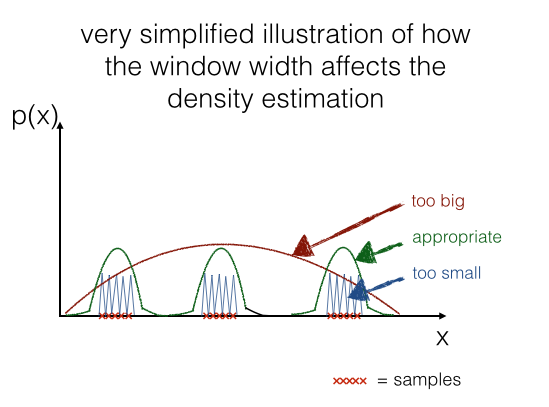

In [125]:
# 최적의 smoothing parameter "h" 구하기
import operator

# generate a range of 400 window widths between 0 < h < 1
h_range = np.linspace(0.001, 1, 400)

# calculate the actual density at the center [0, 0]
mu = np.array([[0],[0]])
cov = np.eye(2)
actual_pdf_val = pdf_multivariate_gauss(np.array([[0],[0]]), mu, cov)

# get a list of the differnces (|estimate-actual|) for different window widths
parzen_estimates = [np.abs(parzen_window_est(x_2Dgauss, h=i, center=[0, 0])
               - actual_pdf_val) for i in h_range]

# get the window width for which |estimate-actual| is closest to 0
min_index, min_value = min(enumerate(parzen_estimates), key=operator.itemgetter(1))

print('Optimal window width for this data set: ', h_range[min_index])

Optimal window width for this data set:  0.5192781954887218


In [127]:
import prettytable

p1 = parzen_window_est(x_2Dgauss, h=h_range[min_index], center=[0, 0])
p2 = parzen_window_est(x_2Dgauss, h=h_range[min_index], center=[0.5, 0.5])
p3 = parzen_window_est(x_2Dgauss, h=h_range[min_index], center=[0.3, 0.2])

mu = np.array([[0],[0]])
cov = np.eye(2)

a1 = pdf_multivariate_gauss(np.array([[0],[0]]), mu, cov)
a2 = pdf_multivariate_gauss(np.array([[0.5],[0.5]]), mu, cov)
a3 = pdf_multivariate_gauss(np.array([[0.3],[0.2]]), mu, cov)

results = prettytable.PrettyTable(["", "predicted", "actual"])
results.add_row(["p([0,0]^t",p1, a1])
results.add_row(["p([0.5,0.5]^t",p2, a2])
results.add_row(["p([0.3,0.2]^t",p3, a3])

print(results)

+---------------+---------------------+---------------------+
|               |      predicted      |        actual       |
+---------------+---------------------+---------------------+
|   p([0,0]^t   | 0.15909521516606848 | 0.15915494309189535 |
| p([0.5,0.5]^t | 0.11385135444285088 | 0.12394999430965298 |
| p([0.3,0.2]^t |  0.1368441361218631 | 0.14913891880709737 |
+---------------+---------------------+---------------------+


In [128]:
# 각 kernel에 따른 결과값 비교
from scipy.stats import kde
import prettytable

gde = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.3)


results = prettytable.PrettyTable(["", "p(x) hypercube kernel",
    "p(x) Gaussian kernel", "p(x) actual"])
results.add_row(["p([0,0]^t",p1, gde.evaluate(np.array([[0],[0]]))[0], a1])
results.add_row(["p([0.5,0.5]^t",p2, gde.evaluate(np.array([[0.5],[0.5]]))[0], a2])
results.add_row(["p([0.3,0.2]^t",p3, gde.evaluate(np.array([[0.3],[0.2]]))[0], a3])

print(results)

+---------------+-----------------------+----------------------+---------------------+
|               | p(x) hypercube kernel | p(x) Gaussian kernel |     p(x) actual     |
+---------------+-----------------------+----------------------+---------------------+
|   p([0,0]^t   |  0.15909521516606848  | 0.14781355097018534  | 0.15915494309189535 |
| p([0.5,0.5]^t |  0.11385135444285088  | 0.11411880140247675  | 0.12394999430965298 |
| p([0.3,0.2]^t |   0.1368441361218631  | 0.13742367333412692  | 0.14913891880709737 |
+---------------+-----------------------+----------------------+---------------------+


C:\Users\ppuya\anaconda3\envs\jff\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


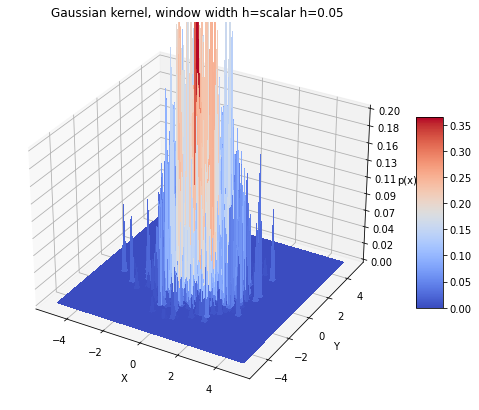

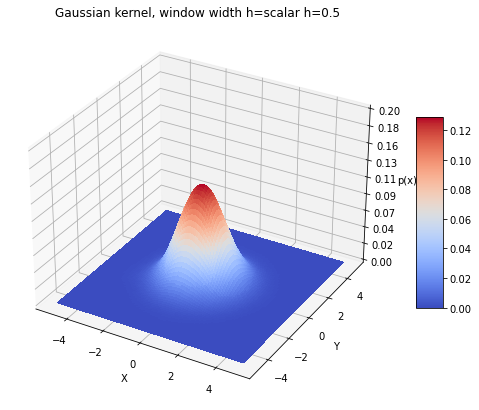

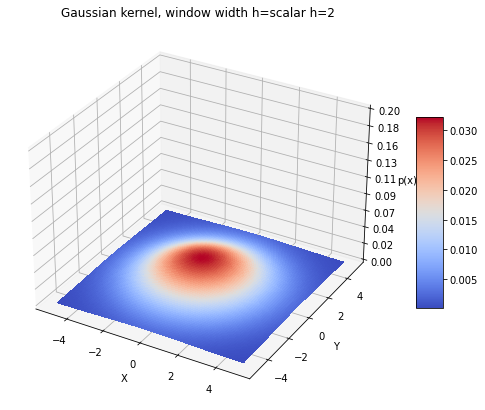

In [129]:
# h값에 따른 smoothing시각화
from mpl_toolkits.mplot3d import Axes3D

X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X,Y = np.meshgrid(X,Y)
gde_01 = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.01)
gde_5 = kde.gaussian_kde(x_2Dgauss.T, bw_method=0.5)
gde_20 = kde.gaussian_kde(x_2Dgauss.T, bw_method=2)

for bwmethod,t in zip([gde_01, gde_5, gde_20],
        ['scalar h=0.05', 'scalar h=0.5', 'scalar h=2']):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    Z = bwmethod(np.array([X.ravel(),Y.ravel()]))
    Z = Z.reshape(100,100)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

    ax.set_zlim(0, 0.2)
    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('p(x)')

    plt.title('Gaussian kernel, window width h=%s' %t)
    fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)
    plt.show()

In [ ]:
* 위 h값을 통해 spiky한 혹은, 완만한 밀도분포가 생성되는것을 볼 수 있음

## Local Outlier Factor(LOF)

In [ ]:
* 이상치 스코어를 산출 할때, "주변부"의 밀도도 같이 고려하여 이상여부를 나타내고자함
* 특정 데이터 주변 밀도가 작지만, 주변부 데이터들은 밀도가 높을때 --> 이상치라고 판단함

In [130]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt

In [131]:
random.seed(1)
x, _ = make_blobs(n_samples=200, centers=1, cluster_std=.3, center_box=(10,10))

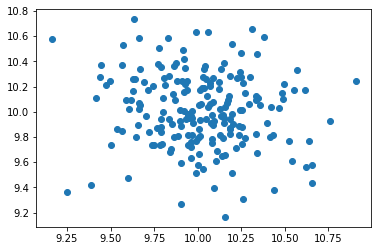

In [132]:
plt.scatter(x[:,0], x[:,1])
plt.show()

In [134]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=.03)
y_pred = lof.fit_predict(x)

In [135]:
lofs_index = where(y_pred==-1)
values = x[lofs_index]

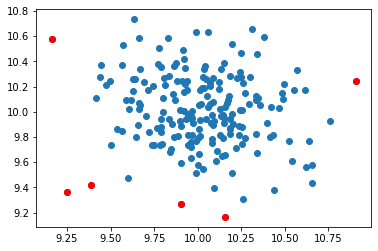

In [136]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(values[:,0],values[:,1], color='r')
plt.show()

In [141]:
# 모델 구축 시,
model = LocalOutlierFactor(n_neighbors=20) 

model.fit_predict(x)
lof = model.negative_outlier_factor_ 

thresh = quantile(lof, .03)
print(thresh)

-1.819148296090704


In [143]:
index = where(lof<=thresh)
values = x[index]

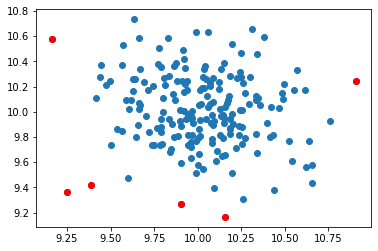

In [144]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()